# Automatic program Repair (APR)

In [ ]:

import sys

import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
from data_loader.loader import load_buggy_dataset, load_data
from bug_detective.detective import process_prompt_dataset

# Add the data_loader module to the path

# Import data loader functions

# Load sample train data
print("Loading sample train data...")

# Load buggy train dataset
buggy_train_df = load_buggy_dataset('train')


Loading sample train data...


In [ ]:

sample_data = buggy_train_df.sample(n=100, random_state=0)
# sample_data = load_data("data_20250703_235942.pkl")
print(f"Sample data shape: {sample_data.shape}")
print(f"Sample data columns: {sample_data.columns.tolist()}")


In [ ]:
from llm_models.open_router import create_openrouter_model

qwen_model = create_openrouter_model(
    model_name="qwen/qwen-2.5-coder-32b-instruct",
    temperature=0.0,
    max_tokens=1000
)
gpt_4o_mini_model = create_openrouter_model(
    model_name="openai/gpt-4o-mini",
    temperature=0.0,
    max_tokens=1000
)






In [ ]:

# outputs_qwen = await process_prompt_dataset(qwen_model, sample_data)
# sample_data['response_qwen-2.5-coder-32b-instruct'] = outputs_qwen

outputs_gpt_4o_mini = await process_prompt_dataset(gpt_4o_mini_model, sample_data)
sample_data['response_gpt-4o-mini'] = outputs_gpt_4o_mini


In [ ]:
sample_data.head()

### Save data

In [ ]:
import pickle
import pandas as pd
from datetime import datetime
from pathlib import Path
import os
data_path = '/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
file_name = f'data_{timestamp}'
file_name += '.pkl'
file_path = os.path.join(data_path, file_name)
Path(data_path).mkdir(parents=True, exist_ok=True)
with open(file_path, 'wb') as f:
    pickle.dump(sample_data, f)
print(f"Data saved to: {file_path}")


### Load Data

In [2]:
sample_data = load_data("data_20250706_152806.pkl")
print("Number of rows: ", len(sample_data))
print("LLM Responses: ", [column for column in sample_data.columns if "response" in column])

Number of rows:  100
LLM Responses:  ['response_qwen-2.5-coder-32b-instruct', 'response_gpt-4o-mini']


In [3]:
from utils.visualization import compare_groundtruth_vs_corrected_histograms, compare_metrics_versus_bug_histograms, plot_column_distribution


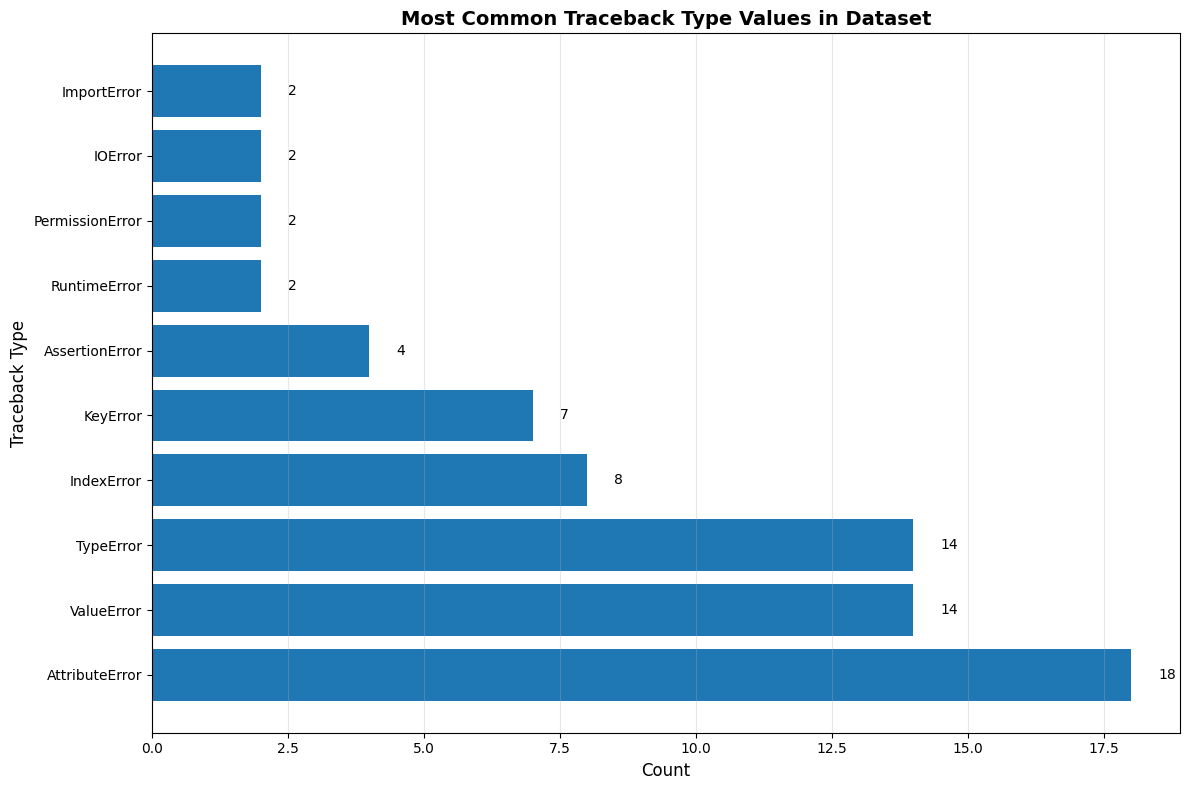

Total unique traceback_type values: 37
Total samples: 100

Top 5 most common traceback_type values:
1. AttributeError: 18 (18.0%)
2. ValueError: 14 (14.0%)
3. TypeError: 14 (14.0%)
4. IndexError: 8 (8.0%)
5. KeyError: 7 (7.0%)


In [4]:
plot_column_distribution(sample_data, 'traceback_type')

In [7]:
sample_data[sample_data['traceback_type'] == 'AttributeError'].head()

,after_merge,before_merge,filename,full_file_code_after_merge,full_file_code_before_merge,function_name,url,source code and errors,full_traceback,traceback_type,before_merge_without_docstrings,after_merge_without_docstrings,before_merge_docstrings,after_merge_docstrings,path_to_snippet_before_merge,path_to_snippet_after_merge,response_qwen-2.5-coder-32b-instruct,response_gpt-4o-mini
92473,"def get_feature_meta(column, preprocessing...","def get_feature_meta(column, preprocessing...",ludwig/features/sequence_feature.py,#! /usr/bin/env python\n# coding=utf-8\n# Copy...,#! /usr/bin/env python\n# coding=utf-8\n# Copy...,SequenceFeatureMixin.get_feature_meta,https://github.com/ludwig-ai/ludwig/issues/1040,"[{'piece_type': 'other', 'piece_content': 'hyp...",----------------------------------------------...,AttributeError,"def get_feature_meta(column, preprocessing...","def get_feature_meta(column, preprocessing...",[],[],buggy_snippets_files/7bff162e0094c336f001d160f...,buggy_snippets_files/7bff162e0094c336f001d160f...,"def get_feature_meta(column, preprocessing_par...","def get_feature_meta(column, preprocessing_par..."
85323,"async def backfill(\n self, dest: s...","async def backfill(\n self, dest: s...",synapse/federation/federation_client.py,"# -*- coding: utf-8 -*-\n# Copyright 2015, 201...","# -*- coding: utf-8 -*-\n# Copyright 2015, 201...",FederationClient.backfill,https://github.com/matrix-org/synapse/issues/6978,"[{'piece_type': 'other', 'piece_content': '202...","2020-02-24 14:00:10,088 - synapse.federation.f...",AttributeError,"async def backfill(\n self, dest: s...","async def backfill(\n self, dest: s...",[],[],buggy_snippets_files/2f6c7e336ace9cbd98254d0be...,buggy_snippets_files/2f6c7e336ace9cbd98254d0be...,"async def backfill(\n self, dest: str, room...","async def backfill(\n self, dest: str, room..."
571464,"def finish_job_fact_cache(self, destinatio...","def finish_job_fact_cache(self, destinatio...",awx/main/models/jobs.py,"# Copyright (c) 2015 Ansible, Inc.\n# All Righ...","# Copyright (c) 2015 Ansible, Inc.\n# All Righ...",Job.finish_job_fact_cache,https://github.com/ansible/awx/issues/5935,"[{'piece_type': 'error message', 'piece_conten...","2020-02-13 19:10:29,258 ERROR awx.main.task...",AttributeError,"def finish_job_fact_cache(self, destinatio...","def finish_job_fact_cache(self, destinatio...",[],[],buggy_snippets_files/5aef3584eb4e941be904b15bb...,buggy_snippets_files/5aef3584eb4e941be904b15bb...,"def finish_job_fact_cache(self, destination, m...","def finish_job_fact_cache(self, destination, m..."
568443,"def processIncomingPacket(self, data, call...","def processIncomingPacket(self, data, call...",pymodbus/framer/binary_framer.py,import struct\nfrom pymodbus.exceptions import...,import struct\nfrom pymodbus.exceptions import...,ModbusBinaryFramer.processIncomingPacket,https://github.com/riptideio/pymodbus/issues/377,"[{'piece_type': 'error message', 'piece_conten...","client = ModbusSerialClient(port='notexist', m...",AttributeError,"def processIncomingPacket(self, data, call...","def processIncomingPacket(self, data, call...",[],[],buggy_snippets_files/c8098f41d1b4d87345f9ce75b...,buggy_snippets_files/c8098f41d1b4d87345f9ce75b...,"def processIncomingPacket(self, data, callback...","def processIncomingPacket(self, data, callback..."
548745,"def get_dataset(self, key, info, out=None,...","def get_dataset(self, key, info, out=None,...",satpy/readers/hrit_base.py,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,HRITFileHandler.get_dataset,https://github.com/pytroll/satpy/issues/123,"[{'piece_type': 'source code', 'piece_content'...",[INFO: 2017-12-12 08:14:04 : satpy.writers.cf_...,AttributeError,"def get_dataset(self, key, info, out=None,...","def get_dataset(self, key, info, out=None,...",[],[],buggy_snippets_files/7e60c86965ec1696229d90ade...,buggy_snippets_files/7e60c86965ec1696229d90ade...,"def get_dataset(self, key, info, out=None, xsl...","from cf

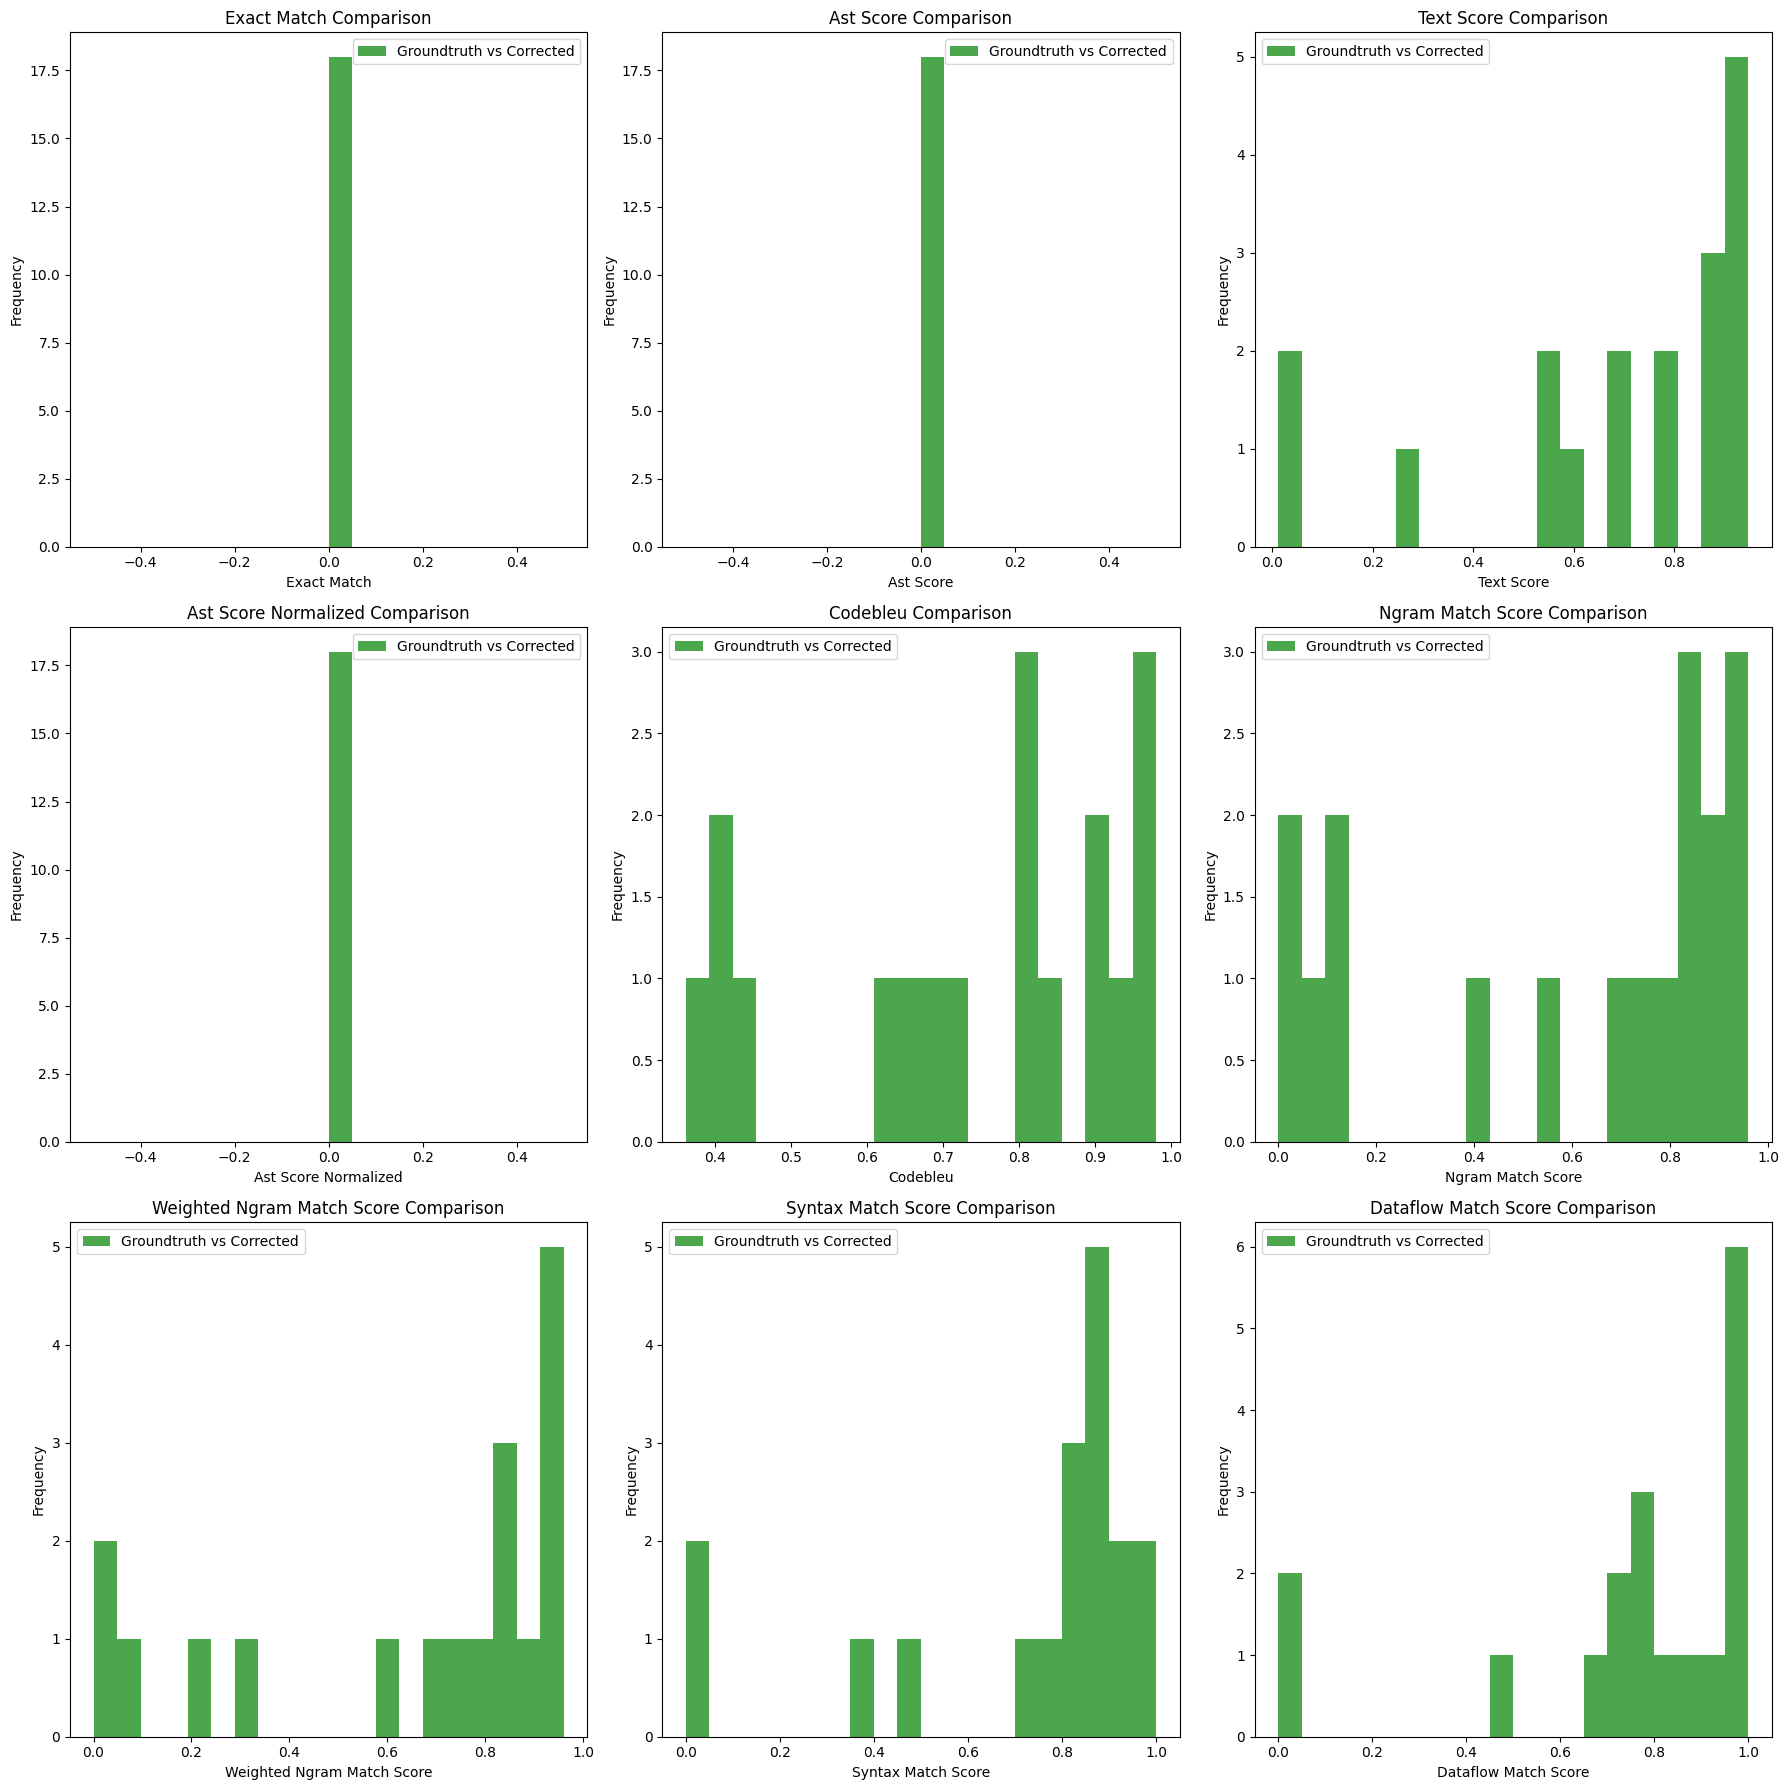

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.000, std=0.000
Text Score - Groundtruth vs Corrected: mean=0.686, std=0.291
Ast Score Normalized - Groundtruth vs Corrected: mean=0.000, std=0.000
Codebleu - Groundtruth vs Corrected: mean=0.734, std=0.204
Ngram Match Score - Groundtruth vs Corrected: mean=0.593, std=0.358
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.645, std=0.345
Syntax Match Score - Groundtruth vs Corrected: mean=0.728, std=0.300
Dataflow Match Score - Groundtruth vs Corrected: mean=0.749, std=0.301


In [7]:
compare_groundtruth_vs_corrected_histograms(sample_data[sample_data['traceback_type'] == 'AttributeError']['after_merge'],sample_data[sample_data['traceback_type'] == 'AttributeError']['response_gpt-4o-mini'])

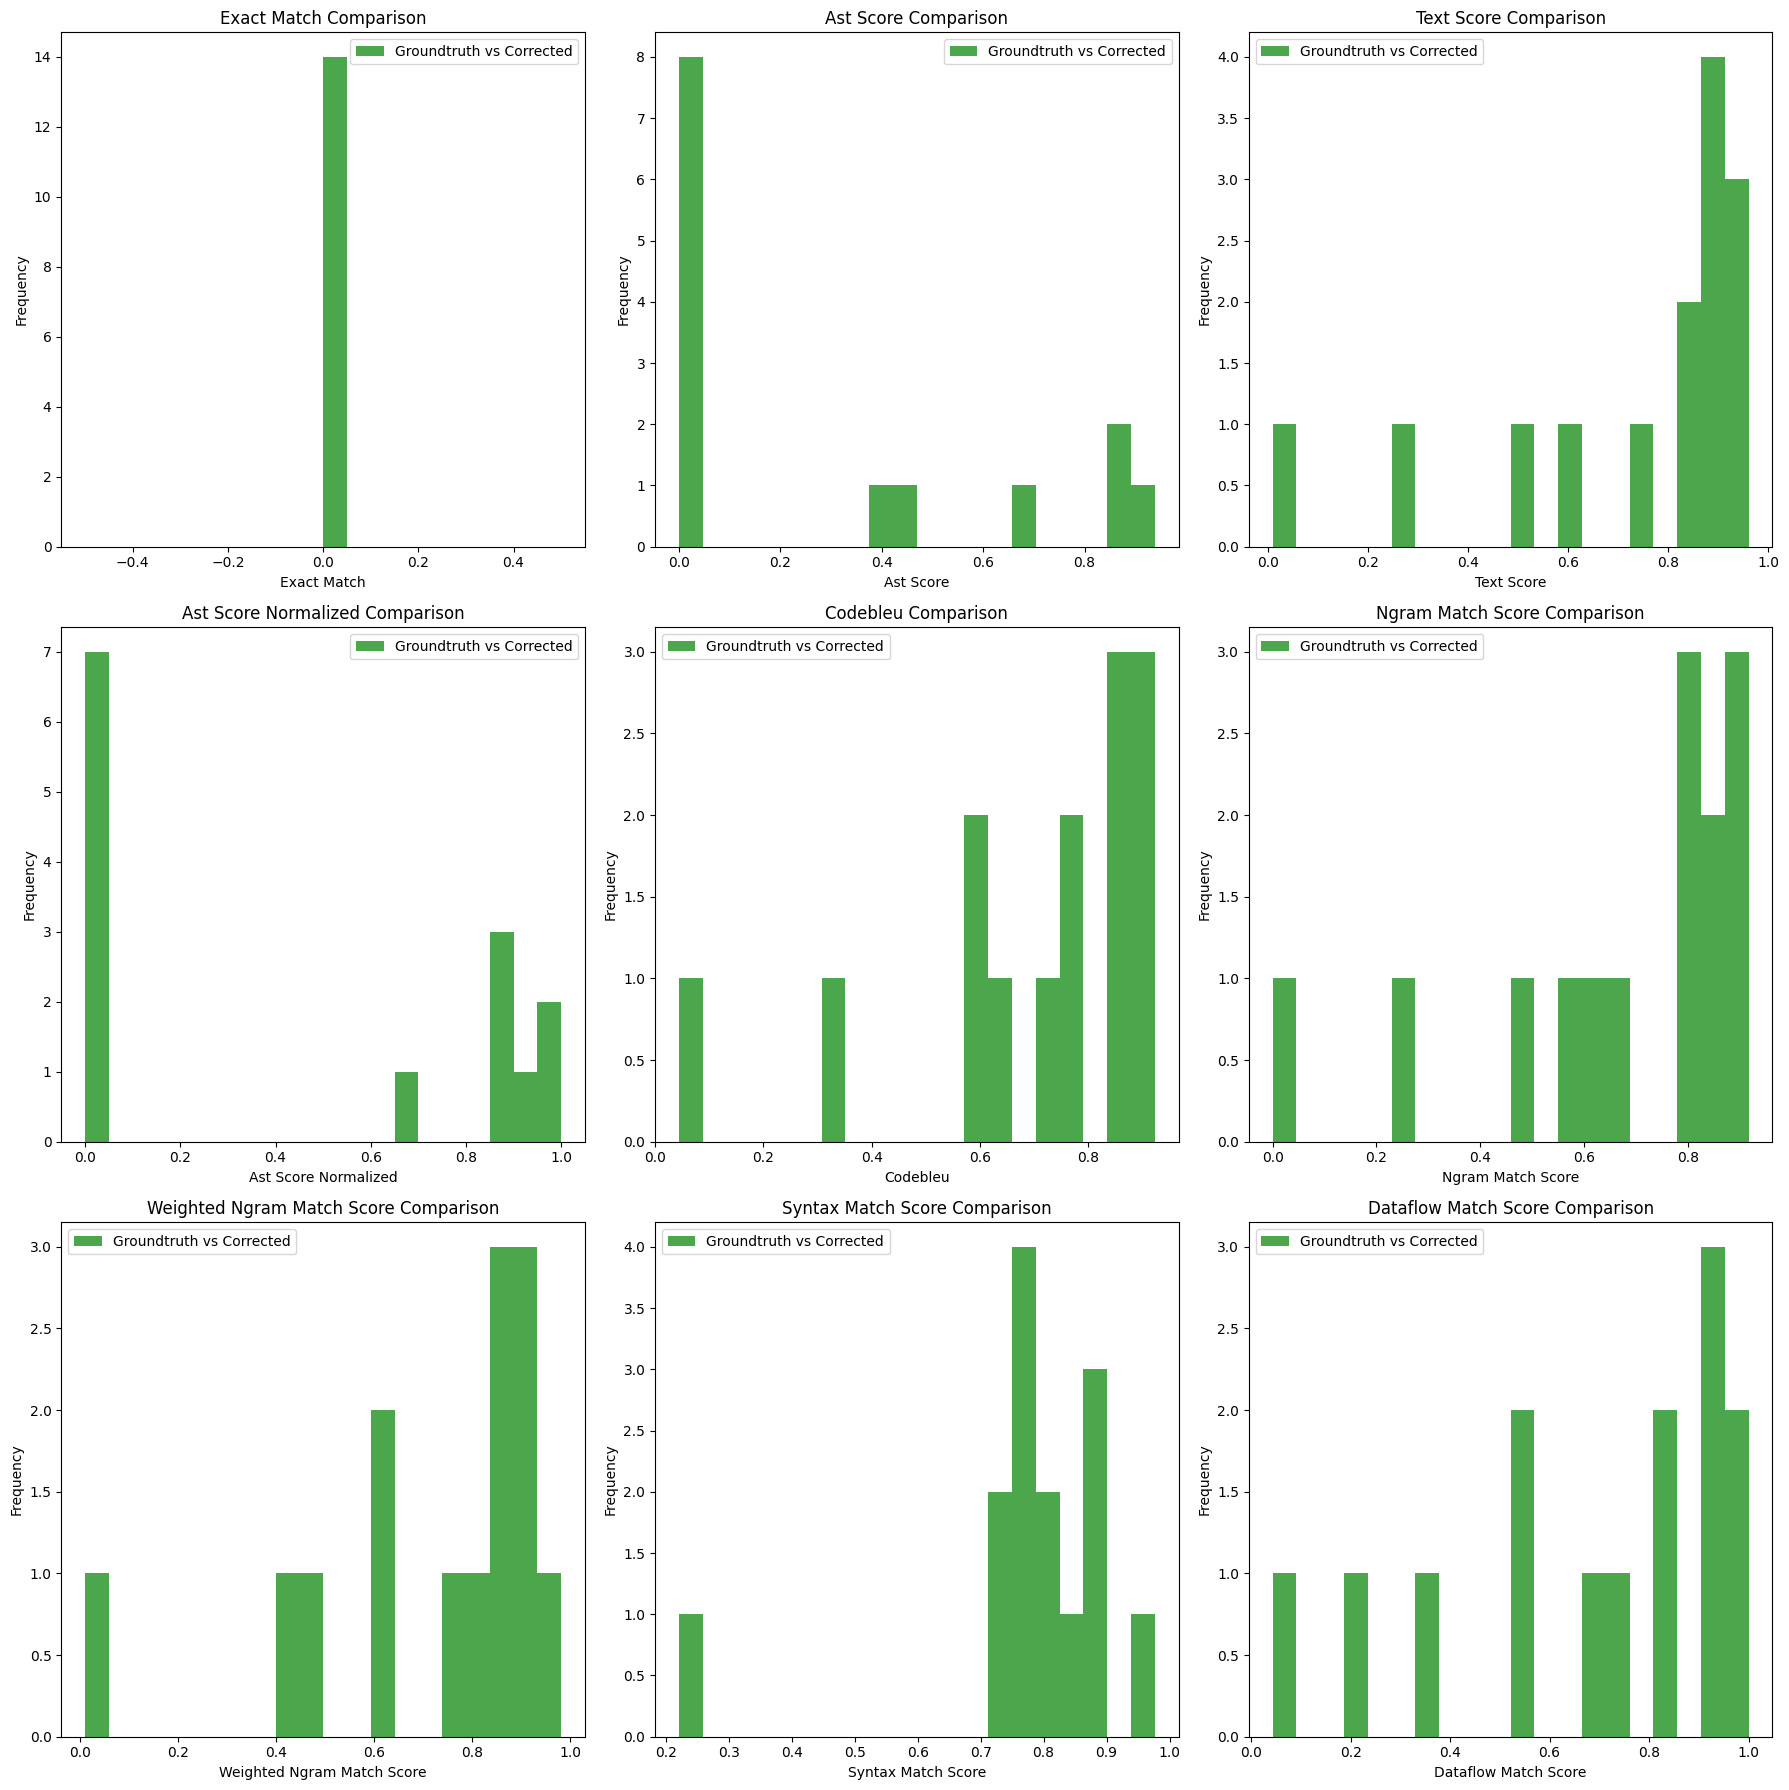

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.295, std=0.369
Text Score - Groundtruth vs Corrected: mean=0.728, std=0.276
Ast Score Normalized - Groundtruth vs Corrected: mean=0.443, std=0.448
Codebleu - Groundtruth vs Corrected: mean=0.702, std=0.240
Ngram Match Score - Groundtruth vs Corrected: mean=0.668, std=0.256
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.719, std=0.255
Syntax Match Score - Groundtruth vs Corrected: mean=0.778, std=0.169
Dataflow Match Score - Groundtruth vs Corrected: mean=0.676, std=0.289


In [6]:
compare_groundtruth_vs_corrected_histograms(sample_data[sample_data['traceback_type'] == 'ValueError']['after_merge'],sample_data[sample_data['traceback_type'] == 'ValueError']['response_gpt-4o-mini'])

In [ ]:
# Call the function with the lists
compare_metrics_versus_bug_histograms(sample_data['before_merge'],sample_data['after_merge'],sample_data['response_qwen-2.5-coder-32b-instruct'])

In [ ]:
codebleu_scores = codebleu(sample_data['before_merge'].tolist(), sample_data['after_merge'].tolist())
print(codebleu_scores)

In [ ]:
check = load_data("data_20250705_180849.pkl")
check.head()

In [ ]:
print(sample_data['response_gpt-4o-mini'].iloc[0])

NameError: name 'sample_data' is not defined